## imports

In [9]:
pip install pandas 

     |████████████████████████████████| 12.3 MB 1.7 MB/s eta 0:00:01    |████████████████▎               | 6.3 MB 2.7 MB/s eta 0:00:03     |█████████████████▉              | 6.9 MB 1.1 MB/s eta 0:00:06
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Importation des bibliothèques 
import ccxt
#import tqdm as tq
from binance import Client
import numpy as np 
import pandas as pd
from datetime import datetime
from time import time 
from datetime import timedelta
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Initialisation


## Fonctions 

In [13]:

def to_timestamp(date):
    element = datetime.strptime(date,"%Y-%m-%d")
    timestamp = int(datetime.timestamp(element))*1000
    return timestamp

def convert_time(dataframe): 
  temps=[]
  for elm in  dataframe['timestamp']:
    temps.append(datetime.fromtimestamp(elm/1000))     
  dataframe['timestamp'] =pd.DatetimeIndex(pd.to_datetime(temps)).tz_localize('UTC').tz_convert('UTC')
  return dataframe


def detection_mauvais_shape(dictionaire_crypto):
  liste_shape =[]
  liste_crypto=[]
  boulean =[]
  for elm in dictionaire_crypto :
    liste_shape.append(dictionaire_crypto[elm].shape[0])
    liste_crypto.append(elm)
  for elm in liste_shape :
    if elm < np.max(liste_shape):
      boulean.append(True)
    else :
      boulean.append(False)
  boulean,liste_crypto = np.array(boulean),np.array(liste_crypto)
  return  liste_crypto[boulean]

def correction_shape(dictionaire_crypto, array):
    max_shape=[]
    shape_a_manque =[]
    liste_final=[]
    nom_shape_a_manque=[]

    #onc cherche le shape maximun dans tous le array
    for elm in dictionaire_crypto:
      max_shape.append(dictionaire_crypto[elm].shape[0])
    max_shape = np.max(max_shape)

    # on calcul le shape manquant dans le array
    for elm1 in array :
       shape_a_manque.append(max_shape - dictionaire_crypto[elm1].shape[0])
       nom_shape_a_manque.append(elm1)
    for shape, nom  in zip(shape_a_manque, nom_shape_a_manque) :
        liste_final = [ np.ones(shape),np.zeros(shape)]
        df_liste_final = pd.DataFrame(np.transpose(liste_final), columns=[nom+'_open',nom+'_close'])
        dictionaire_crypto[nom] = pd.concat((df_liste_final,dictionaire_crypto[nom]), axis=0)
    return dictionaire_crypto

    
def generation_date (dataframe, delta_pas):
  test_list=[]
  pas = timedelta(hours = delta_pas)
  date_ini = dataframe.index[::-1][0]
  inverse_time =dataframe.index[::-1]
  for i in range (len(inverse_time)):
    print("date_ini",date_ini)
    print("pas",pas)
    print("i",i)
    test_list.append(date_ini-pas*i)
  test_list = test_list[::-1]
  return test_list

def correction_date(crypto, array_mauvais_shape, delta):
    for elm in array_mauvais_shape :
            print('elm',elm)
            print(int(delta[:1]))
            print(crypto[elm],'\n\n\n\n\n\n')

            crypto[elm]['timestamp'] = generation_date (crypto[elm], int(delta[:1]))
            crypto[elm] = crypto[elm].set_index('timestamp') 
    return crypto

def variation(dataframe) :
  """ 
  Calcul  de la variation
  ENtRE => dataframe   exemple crypto['eth/usdt']
  SORTIE =>  pandas.core.series.Series
  """
  open_ = dataframe[dataframe.columns[0]]
  close = dataframe[dataframe.columns[1]]
  serie_variation = ((close)/open_)
  print(dataframe.columns[0].split("/")[1])
  df_serie_variation = pd.DataFrame(serie_variation, dataframe.index, columns=[dataframe.columns[0].split("/")[0]+'_var'])
  return df_serie_variation

def fonction_cumul(dataframe, name_crypto ):
    dataframe['cumul_'+name_crypto.split("/")[0]]=((dataframe['coef_multi_'+name_crypto.split("/")[0]])*100)-100
    return dataframe



def coef_multi(dataframe):
  """ Calcul du coef_multiplicateur
      entre =>  Dataframe  exemple crypto['eth/usdt']
      sortie => pandas.Series du coeffitient multiplicateur
  """
  liste_finale = []
  for i in  range (len(dataframe.index)):
    if dataframe[dataframe.columns[2]][i]==0:
      liste_finale.append(0)
    else:
      break
  var_zeros = dataframe[dataframe.columns[2]][:i]
  var_sans_zero = dataframe.iloc[i:][dataframe.columns[2]]
  var_sans_z_cumprod = var_sans_zero.cumprod()
  coef_multi = pd.concat([var_zeros,var_sans_z_cumprod])
  return coef_multi

def variationN(cryptos, ni):
    if (ni == 'N'):
        for crypto in cryptos:
            
            cryptos[crypto]["Variation_" + crypto] = cryptos[crypto][crypto + "_close"] / cryptos[crypto][
                crypto + "_open"]
            cryptos[crypto]["Variation_N_" + crypto] = cryptos[crypto][crypto + "_close"] / cryptos[crypto][
                crypto + "_open"]
    elif (ni == 'N-1'):
        for crypto in cryptos:
            
            cryptos[crypto]["Variation_N_" + crypto] = cryptos[crypto][crypto + "_close"] / cryptos[crypto][
                crypto + "_open"]
            cryptos[crypto]["Variation_" + crypto] = 0.0
            cryptos[crypto]["Variation_" + crypto][0] = float(cryptos[crypto][crypto+ "_close"][0]) /float(cryptos[crypto][crypto + "_open"][0])
            for j in range(1,len(cryptos[crypto])):
                cryptos[crypto]["Variation_" + crypto][j] = cryptos[crypto][crypto + "_close"][j] / cryptos[crypto][crypto + "_open"][j-1]
    elif (ni == 'N-2'):
        for crypto in cryptos:
            
            cryptos[crypto]["Variation_N_" + crypto] = cryptos[crypto][crypto + "_close"] / cryptos[crypto][
                crypto + "_open"]
            cryptos[crypto]["Variation_" + crypto] = 0.0
            cryptos[crypto]["Variation_" + crypto][0] = float(cryptos[crypto][crypto + "_close"][0]) / float(
                cryptos[crypto][crypto + "_open"][0])
            cryptos[crypto]["Variation_" + crypto][1] = float(cryptos[crypto][crypto + "_close"][1]) / float(
                cryptos[crypto][crypto + "_open"][0])
            for j in range(2, len(cryptos[crypto])):
                cryptos[crypto]["Variation_" + crypto][j] = cryptos[crypto][crypto + "_close"][j] / \
                                                                 cryptos[crypto][crypto + "_open"][j - 2]
    return (cryptos)

def coeffMulti(cryptos):
    for crypto in cryptos:
        for i in range(len(cryptos[crypto].index)):
            if (i == 0):
                cryptos[crypto]["Coeff_mult_" + crypto] = cryptos[crypto][crypto + "_close"][0] / \
                                                               cryptos[crypto][crypto + "_open"][0]
            else:
                cryptos[crypto]["Coeff_mult_" + crypto][i] = cryptos[crypto]["Variation_N_" + crypto][i] * \
                                                                  cryptos[crypto]["Coeff_mult_" + crypto][i - 1]
                # print(cryptos[crypto]["Variation_N_" + crypto[:-5]][i]," * ",  cryptos[crypto]["Coeff_mult_" + crypto[:-5]][i - 1] ," = ",cryptos[crypto]["Coeff_mult_" + crypto[:-5]][i] )

    return cryptos


def mergeCryptoTogether(cryptos):
    for i in cryptos:
        cryptos["BOT_MAX"] = cryptos[i].copy()
        cryptos["BOT_MAX"].rename(columns={"Variation_" + i: "Variation_BOTMAX"}, inplace=True)
        cryptos["BOT_MAX"].rename(columns={i + "_close": "Variation2BOTMAX"}, inplace=True)
        cryptos["BOT_MAX"].rename(columns={"Coeff_mult_" + i: "Coeff_mult_BOTMAX"}, inplace=True)
        cryptos["BOT_MAX"].rename(columns={"Variation_N_" + i: "Variation_BOTMAX_N"}, inplace=True)
        break
    cryptos = pd.concat(cryptos, axis=1)
    return cryptos

def botMax(cryptos):
    maxis = []
    for i in range(len(cryptos)):
        v = []
        k = 0
        for j in range(len(cryptos.iloc[i])):
            if (k == 3):
                v.append(cryptos.iloc[i].iloc[j])
            elif (k == 4):
                k = -1
            k += 1
        maxx = max(v)
        maxis.append(v.index(maxx))
        cryptos["BOT_MAX"]["Variation_BOTMAX"][i] = maxx
    return cryptos, maxis

def botMaxVariation2(cryptos, maxis):
    botNames = []
    for crypto in cryptos:
        if (crypto[0] not in botNames):
            botNames.append(crypto[0])
    for i in range(len(cryptos)):
        botName = botNames[maxis[i]]
        cryptos["BOT_MAX"]["Variation_BOTMAX_N"][i] = cryptos[botName]["Variation_N_" + botName][i]
    for i in range(0, len(cryptos) - 1):
        botName = botNames[maxis[i]]
        cryptos["BOT_MAX"]["Variation2BOTMAX"][i + 1] = cryptos[botName]["Variation_N_" + botName][i + 1]
    cryptos["BOT_MAX"]["Variation2BOTMAX"][0] = 0

    return cryptos

def coeffMultiBotMax(cryptos):
    cryptos["BOT_MAX"]["Coeff_mult_BOTMAX"][0] = 1.000
    for i in range(1, len(cryptos)):
        cryptos["BOT_MAX"]["Coeff_mult_BOTMAX"][i] = cryptos["BOT_MAX"]["Coeff_mult_BOTMAX"][i - 1] * \
                                                     cryptos["BOT_MAX"]["Variation2BOTMAX"][i]
    return cryptos

def coefmultiFinal(cryptos):
    tabe = {}
    for crypto in cryptos:
        if (crypto[1].find("Coeff_mult_") == 0):
            tabe[crypto[1]] = cryptos[crypto]
    tabe = pd.DataFrame(tabe)
    return tabe

def convert_stamps_to_time (stamps):  


    time_converted = pd.to_datetime(datetime.fromtimestamp(stamps/1000)).tz_localize('UTC').tz_convert('UTC')
    return time_converted

# Récupération de tous les tickers
def best_10_cyptos(exchange):
    markets = exchange.fetch_tickers() 
    df_volume = pd.DataFrame(markets).T["quoteVolume"]
    df_volume_usdt = df_volume[df_volume.index.str.endswith('/USDT')]    
    df_10_bestcryptos = df_volume_usdt.sort_values(ascending=False)[:10]
    list_10_best_cryptos = df_10_bestcryptos.index
    return list_10_best_cryptos


def dowload_data(market, delta,star_time, end_time):
    crypto={}
    for elm in market :
        x = elm.lower().split("/")[0]+"_"+delta
        crypto[x] = client.get_historical_klines(elm.replace("/","").upper(), delta,star_time, end_time)
        crypto[x]=pd.DataFrame(data=crypto[x], columns=['timestamp', x+'_open', 'high', 'low', x+'_close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ]) 
        crypto[x] = crypto[x][['timestamp', x+'_open', x+'_close']]
        crypto[x] = convert_time(crypto[x])
        crypto[x] = crypto[x].astype({x+'_open': 'float64',x+'_close': 'float64'})
        crypto[x] = crypto[x].set_index('timestamp')
    return crypto

def dowload_data_with_volume(market, delta,star_time, end_time):
    crypto={}
    for elm in market :
        x = elm.lower().split("/")[0]+"_"+delta
        crypto[x] = client.get_historical_klines(elm.replace("/","").upper(), delta,star_time, end_time)
        crypto[x]=pd.DataFrame(data=crypto[x], columns=['timestamp', x+'_open', 'high', 'low', x+'_close', x+'_volume', 'close_time', x+'_quote_av', 'trades', 'tb_base_av', x+'_tb_quote_av', 'ignore' ]) 
        crypto[x] = crypto[x][['timestamp', x+'_open', x+'_close', x+'_volume', x+'_quote_av', x+'_tb_quote_av']]
        crypto[x] = convert_time(crypto[x])
        crypto[x] = crypto[x].astype({x+'_open': 'float64',
                                      x+'_close': 'float64', 
                                      x+'_volume': 'float64',
                                      x+'_quote_av':'float64',
                                      x+'_tb_quote_av': 'float64'})
        crypto[x] = crypto[x].set_index('timestamp')
    return crypto

def list_cryptos_endswith_usdt(list_all_cryptos):
     cryptos_usdt = [ crypto for crypto in list_all_cryptos if crypto.endswith('USDT')]
     return cryptos_usdt

## ALgo Cocotier

In [14]:
# la fonction  de l'algorithme cocotier 
def algo_cocotier(list_10_best_cryptos, delta, star_time, end_time, computing, key):   
    crypto = dowload_data_with_volume(list_10_best_cryptos, delta,star_time, end_time)
    array_mauvais_shape = detection_mauvais_shape(crypto)
    crypto = correction_shape(crypto, array_mauvais_shape)
    crypto = correction_date(crypto, array_mauvais_shape, delta)
    crypto = variationN(crypto, computing)
    crypto = coeffMulti(crypto)
    crypto = mergeCryptoTogether(crypto)
    crypto, maxis = botMax(crypto)
    crypto = botMaxVariation2(crypto, maxis)
    crypto = coeffMultiBotMax(crypto)
    coefMulti = coefmultiFinal(crypto)
    star_time = convert_stamps_to_time (star_time)
    end_time = convert_stamps_to_time (end_time)
    value = coefMulti["Coeff_mult_BOTMAX"][-1:].values[0]
    return computing, star_time, end_time, delta, value, key, list_10_best_cryptos 

## Initialisation 

In [20]:
#apiKey ="ZKf8B87CaG00DYggLBZ6iN1YgPhBRbvzYACQCLEvWifLQd3bpgIsV9SpjeoPr9on"
#secret = "iknYxKq29OdAs5uLzuZrTyBbl2aH1V3r6fj1GdJ0UmWwZYMULup0rKSRnJCSNCKT"

apiKey = "vGjZjIU9d93pdkXwUWIqqQjiNfjBJEMuNrheUnQ5FQXNIGohuGHr0gEaYpQoJINL"
secret = "1Z23tY8k4eqVuGcZaDxOWMrGyeJP4dXfTCWgX7HQS2jjepZPEAlOlIe6DjUjZsnO"
exchange = ccxt.binance({
    'apiKey': apiKey,
    'secret': secret,
    'enableRateLimit': True
})

client = Client()  
crypto = {}
boxmax ={}

### les inputs 

In [21]:
# imputs
list_10_best_cryptos = best_10_cyptos(exchange).to_list()
#list_10_best_cryptos = [elm.split("USDT")[0]+"/USDT" for elm in df_final.loc['2022-01-01'][0]]
if  "BTC/USDT" not in list_10_best_cryptos :
    list_10_best_cryptos.insert(0,"BTC/USDT") 

In [22]:
list_10_best_cryptos

['BTC/USDT',
 'ETH/USDT',
 'TUSD/USDT',
 'USDC/USDT',
 'BNB/USDT',
 'BUSD/USDT',
 'XRP/USDT',
 'EDU/USDT',
 'ARB/USDT',
 'IDEX/USDT']

In [239]:
pool_hour = ['4h','6h','8h','12h']
pool_computing = ['N','N-1','N-2']
pool_date = { "bull" :[("2023-01-01", "2023-02-19")]#,("2021-07-19" ,"2021-07-21")],
            #"bear" : [("2021-05-18","2021-05-20"),("2021-11-08","2021-11-10")],
            #"range" : [ ("2022-06-20", "2022-06-22")] 
            }    
file_path = "here the path to save a csv file" # exemple  "c:\name\data\"
name_csv_file= 'result.csv' # you can change a csv name file as you like 

### Calcul de compexité avant de l'ancer l'algo
- Attention ça prend pas en compte  le nombre de ligne (open,close) de chaque cryptos, ni le nobre de poll cryptos .

In [240]:
for key, dates in pool_date.items():
        for start_date, end_date in dates:
            pass
print("compexité O(n^4)  : ", len(pool_date) * len(dates) * len(pool_computing) * len(pool_hour))

compexité O(n^4)  :  12


## Backtest 

In [276]:
result = []
total_iterations = len(pool_date) * len(dates) * len(pool_computing) * len(pool_hour)

with tq.tqdm(total=total_iterations, desc="Barre de progression") as pbar:
    for key, dates in pool_date.items():
        for start_date, end_date in dates:
            for computing in pool_computing:  
                for hour in pool_hour:             
                    star_time = to_timestamp(str(start_date)) 
                    end_time = to_timestamp(str(end_date))
                    result.append(algo_cocotier(list_10_best_cryptos, hour,star_time, end_time, computing, key))
                    pbar.update(1)

df_result = pd.DataFrame(result,columns=["Computing","start_date","end_date","candel","value",'market_type'])

Barre de progression: 100%|██████████| 12/12 [05:23<00:00, 27.00s/it]


## Tableau result ascending sort 

In [277]:
list_10_best_cryptos

['BTC/USDT',
 'PAXG/USDT',
 'BNBUP/USDT',
 'YFII/USDT',
 'MKR/USDT',
 'ILV/USDT',
 'YFI/USDT',
 'GNO/USDT',
 'NMR/USDT',
 'AUTO/USDT',
 'DCR/USDT']

In [278]:
df_result.sort_values('value',ascending=False)

,Computing,start_date,end_date,candel,value,market_type
2,N,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,8h,1.491557,bull
6,N-1,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,8h,1.491557,bull
10,N-2,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,8h,1.491557,bull
0,N,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,4h,1.491041,bull
4,N-1,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,4h,1.491041,bull
8,N-2,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,4h,1.491041,bull
1,N,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,6h,1.490183,bull
5,N-1,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,6h,1.490183,bull
9,N-2,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,6h,1.490183,bull
3,N,2023-01-01 00:00:00+00:00,2023-02-19 00:00:00+00:00,12h,1.488119,bull


## Somme ploting result 

<AxesSubplot: xlabel='candel,Computing,market_type'>

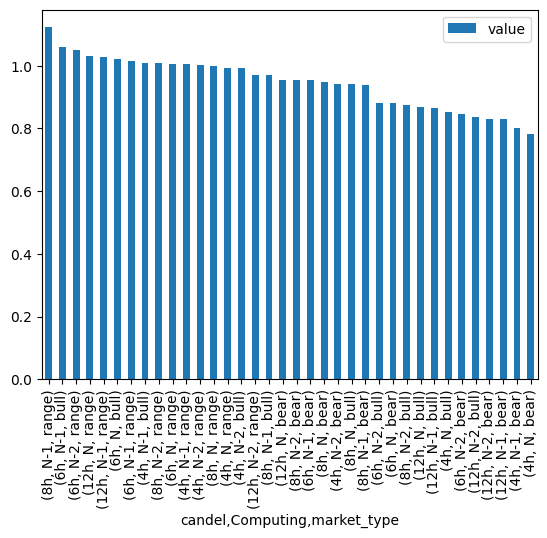

In [ ]:
df_result.groupby(['candel','Computing','market_type']).mean().sort_values('value',ascending=False).plot.bar()

<AxesSubplot: xlabel='candel,Computing'>

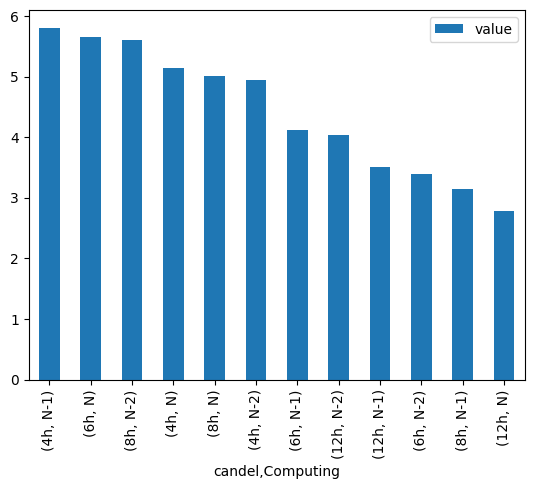

In [ ]:
df_result.groupby(['candel','Computing']).mean().sort_values('value',ascending=False).plot.bar()

<AxesSubplot: xlabel='Computing'>

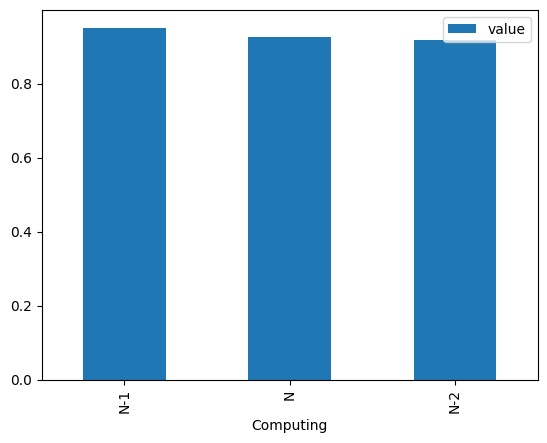

In [ ]:
df_result.groupby('Computing').mean().sort_values('value',ascending=False).plot.bar()

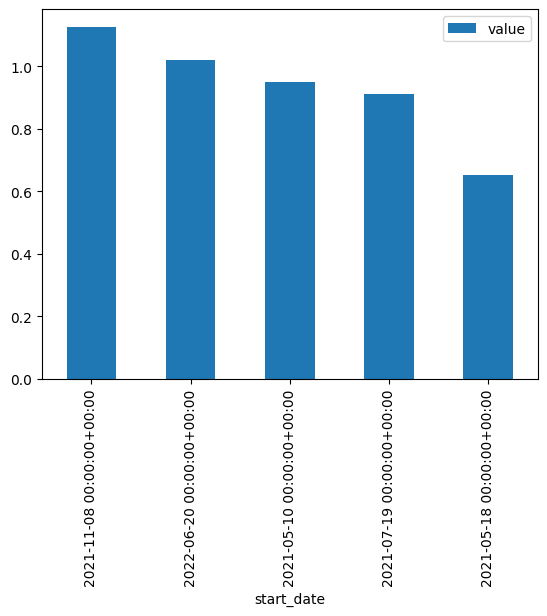

In [ ]:
df_result.groupby('start_date').mean().sort_values('value',ascending=False).plot.bar();

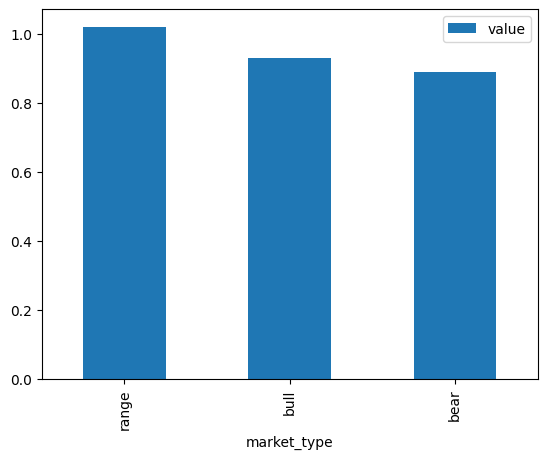

In [ ]:
df_result.groupby(['market_type']).mean().sort_values('value',ascending=False).plot.bar();

## Saving file 

In [ ]:
def save_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

save_to_csv(df_result, name_csv_file)

In [ ]:
def last_crypto_buyed(exchange, market1):
  for elm in market1 :
      etat= pd.DataFrame.from_dict(exchange.fetchMyTrades(elm)).iloc[-1:]
      try :
        if  etat['side'].values[0]== 'buy':
          print(" il ya un buy")
          crypto_a_vendre = etat['symbol']
          print( crypto_a_vendre)#.values[0])
      except KeyError:
        print("il ya pas de side =buy")


## Code pool crypto en focntion du volumes 

### Download all binance cryptocurency 

In [ ]:
# Obtenez une liste de toutes les paires de cryptomonnaies disponibles sur Binance
exchange_info = client.get_exchange_info()
symbols = exchange_info['symbols']
pairs = [symbol['symbol'] for symbol in symbols]

# Paramètres pour l'historique des prix
interval = Client.KLINE_INTERVAL_1DAY  # Intervalles de temps pour récupérer l'historique des prix
start_date = "1 Jan, 2017"  # Date de début de l'historique des prix

# Pour chaque paire de cryptomonnaies, récupérez l'historique des prix et enregistrez-le dans un fichier CSV
for pair in pairs:
    klines = client.get_historical_klines(pair, interval, start_date)
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 
                                       'close', 'volume', 'close_time', 'quote_asset_volume', 
                                       'number_of_trades', 'taker_buy_base_asset_volume', 
                                       'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    filename = 'data_cryptos/'+pair + '.csv'
    df.to_csv(filename)
    print(f'{filename} enregistré.')

### Configuration 

In [170]:
# path from all cryptos 
path="data_cryptos/"

#nbr max of cryptos in the pull 
nbr_crypto_pool =10

### Fonctions 

In [159]:
from datetime import datetime, timedelta
import os


def all_binance_pairs(exchange):
    exchange_info = client.get_exchange_info()
    symbols = exchange_info['symbols']
    pairs = [symbol['symbol'] for symbol in symbols]
    return pairs 

def list_cryptos_endswith_usdt(list_all_cryptos):
     cryptos_usdt = [ crypto for crypto in list_all_cryptos if crypto.endswith('USDT')]
     return cryptos_usdt


def get_files_in_directory(path):
    # Vérifier si le chemin existe et est un dossier
    if os.path.isdir(path):
        # Récupérer tous les noms de fichier dans le dossier
        files = os.listdir(path)
        # Retourner la liste des noms de fichier
        return files
    else:
        # Retourner None si le chemin n'est pas un dossier
        return None
    
def volumes(path,exchange):    
    liste_data_volume_cryptos =[]
    #crypto_list_to_explore =list_cryptos_endswith_usdt(all_binance_pairs(exchange)) # from api all biance pair 
    crypto_list_to_explore = list_cryptos_endswith_usdt([ elm.split(".")[0] for elm in get_files_in_directory(path)]) # from path
    for crypto in crypto_list_to_explore:
        df = pd.read_csv(f'{path}{crypto}.csv',parse_dates=True, index_col='timestamp', 
                            usecols=["timestamp","volume",'quote_asset_volume','taker_buy_quote_asset_volume'])
        df["pair_symbol"]=[crypto for i in range(len(df))]
        liste_data_volume_cryptos.append(df)
    return liste_data_volume_cryptos

def pair_times_table(tout_df):
    i=0
    date_to_check = tout_df.index.drop_duplicates()
    liste_final=[]
    for date in date_to_check:
        try :
            df_date = tout_df.loc[date].sort_values(by="volume",ascending=True)
            liste_final.append((df_date['pair_symbol'].index[0],df_date['pair_symbol'].values))
        except TypeError:
            i+=1
    pair_table = pd.DataFrame(liste_final, columns=["Time","pairs"]).set_index("Time")
    print("i est égale à : " ,i)
    return pair_table

def get_missing_dates(date_list, date_format="%Y-%m-%d"):
    # Convertir les dates en objets datetime
    datetime_list = date_list#[datetime.strptime(date, date_format) for date in date_list]
    # Trier la liste par ordre croissant
    datetime_list.sort()
    # Récupérer la première et la dernière date de la liste
    start_date = datetime_list[0]
    end_date = datetime_list[-1]
    # Calculer la différence entre deux dates
    one_day = timedelta(days=1)
    # Initialiser une liste pour stocker les dates manquantes
    missing_dates = []
    # Parcourir toutes les dates entre la première et la dernière date
    current_date = start_date
    while current_date <= end_date:
        # Vérifier si la date actuelle est dans la liste des dates
        if current_date not in datetime_list:
            # Ajouter la date manquante à la liste des dates manquantes
            missing_dates.append(current_date.strftime(date_format))
        # Passer à la date suivante
        current_date += one_day
    # Retourner la liste des dates manquantes
    return missing_dates

### Excract best crypto volume

In [380]:
#Concat all volumes 
tout_df = pd.concat(volumes(path,exchange))
#resutt
df_final = pair_times_table(tout_df).sort_index(ascending=False)
# 
df_final['pairs'] = df_final['pairs'].apply(lambda x: x[:nbr_crypto_pool])
#check missing dates
print("missing dates :" , True if  get_missing_dates(df_final.index.to_list(), date_format='%Y-%m-%d') else False )

i est égale à :  0
missing dates : False


In [386]:
df_final['pairs'] = df_final['pairs'].apply(lambda x: [i[:-4] + '/' + i[-4:] for i in x])


In [299]:
 limbo = list(df_final.loc['2023-02-20'][0])


In [314]:
df_final.index[0].strftime('%Y-%m-%d')

'2023-02-20'

In [340]:
type(to_timestamp(df_final.index[0].strftime('%Y-%m-%d'))) 

int

In [ ]:
limbo

In [405]:
list_resultat= []
for elm1 ,elm in zip(df_final.index[:2].strftime('%Y-%m-%d'), df_final[:2].values):
    if  "BTC/USDT" not in elm[0] :
        elm[0].insert(0,"BTC/USDT")     
    elm[0]= list(elm[0])   
    list_resultat.append(algo_cocotier(elm[0],'1d', star_time,to_timestamp(elm1), computing, key))


ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None))

In [406]:
pd.DataFrame(list_resultat,colums=['']["Computing","start_date","end_date","candel","value",'market_type','pool_crypto'])

TypeError: list indices must be integers or slices, not tuple

In [395]:
for elm1 ,elm in zip(df_final.index[:2].strftime('%Y-%m-%d'), df_final[:2].values):
    print(elm1)
    print(type(elm1))
    """if  "BTC/USDT" not in elm[0] :
        elm[0].insert(0,"BTC/USDT") 
    print(to_timestamp(elm1), elm[0])
    algo_cocotier(elm[0],'1d', star_time,elm1, computing, key)"""

2023-02-20
<class 'str'>
2023-02-19
<class 'str'>


In [394]:
for elm in df_final.index.strftime('%Y-%m-%d') :
   endtime = to_timestamp(elm)
   

In [369]:
algo_cocotier('BTC/USDT', delta, star_time, end_time, computing, key)

('N-2',
 Timestamp('2023-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2023-02-20 00:00:00+0000', tz='UTC'),
 '1d',
 1.46101200219304,
 'bull')

In [373]:
algo_cocotier(list_10_best_cryptos, '1d', star_time, end_time, computing, key)

('N-2',
 Timestamp('2023-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2023-02-19 00:00:00+0000', tz='UTC'),
 '1d',
 1.4826992640261387,
 'bull')

In [366]:
u = to_timestamp(df_final.index[0].strftime('%Y-%m-%d'))
algo_cocotier(limbo,'1d', star_time,u, computing, key)

('N-2',
 Timestamp('2023-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2023-02-20 00:00:00+0000', tz='UTC'),
 '1d',
 1.46101200219304,
 'bull')